# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지와 텐서플로 버전이 2.0 이상인지 확인합니다.

In [3]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
assert tf.__version__ >= "2.0"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "/Users/jueunhye/Kesera"
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
IMAGES_PATH

'/Users/jueunhye/Kesera/images/ann'

# 퍼셉트론

**노트**: 사이킷런 향후 버전에서 `max_iter`와 `tol` 매개변수의 기본값이 바뀌기 때문에 경고를 피하기 위해 명시적으로 지정합니다.

In [5]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

<ipython-input-5-1399205bb614>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris.target == 0).astype(np.int)


In [6]:
y_pred

array([1])

그림 저장: perceptron_iris_plot


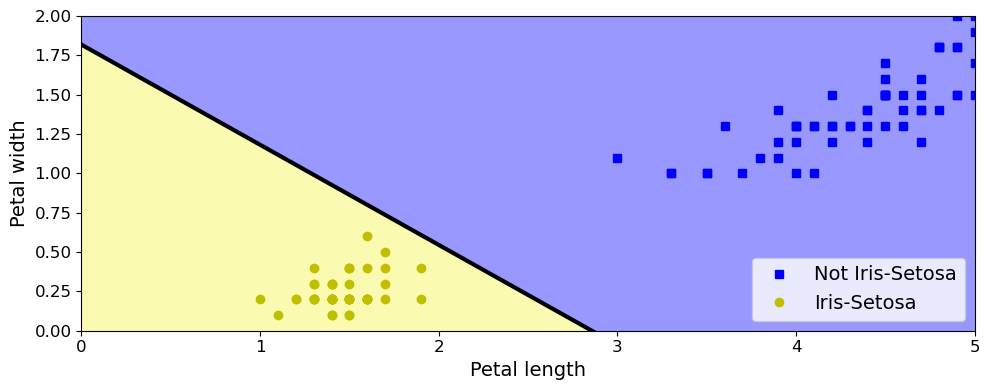

In [7]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# 이미지 분류기 만들기

먼저 텐서플로와 케라스를 임포트합니다.

In [8]:
import tensorflow as tf
from tensorflow import keras

In [9]:
tf.__version__

'2.4.0-rc0'

In [10]:
keras.__version__

'2.4.0'

먼저 MNIST 데이터셋을 로드하겠습니다. 케라스는 `keras.datasets`에 널리 사용하는 데이터셋을 로드하기 위한 함수를 제공합니다. 이 데이터셋은 이미 훈련 세트와 테스트 세트로 나누어져 있습니다. 훈련 세트를 더 나누어 검증 세트를 만드는 것이 좋습니다:

In [11]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

훈련 세트는 60,000개의 흑백 이미지입니다. 각 이미지의 크기는 28x28 픽셀입니다:

In [12]:
X_train_full.shape

(60000, 28, 28)

각 픽셀의 강도는 바이트(0~255)로 표현됩니다:

In [13]:
X_train_full.dtype

dtype('uint8')

전체 훈련 세트를 검증 세트와 (조금 더 작은) 훈련 세트로 나누어 보죠. 또한 픽셀 강도를 255로 나누어 0~1 범위의 실수로 바꾸겠습니다.

In [14]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

맷플롯립의 `imshow()` 함수와 `'binary'` 컬러맵을 사용해 이미지를 출력할 수 있습니다:

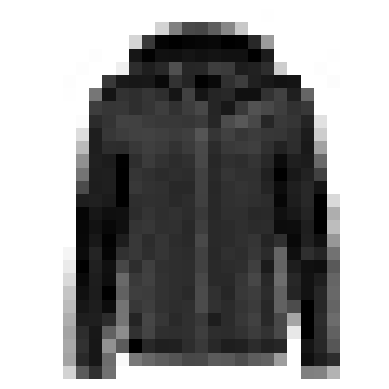

In [15]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

레이블은 0에서 9까지 (uint8로 표현된) 클래스 아이디입니다:

In [16]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

클래스 이름은 다음과 같습니다:

In [17]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

훈련 세트에 있는 첫 번째 이미지는 코트입니다:

In [18]:
class_names[y_train[0]]

'Coat'

검증 세트는 5,000개의 이미지를 담고 있고 테스트 세트는 10,000개의 이미지를 가집니다:

In [19]:
X_valid.shape

(5000, 28, 28)

In [20]:
X_test.shape

(10000, 28, 28)

이 데이터셋에 있는 샘플 이미지를 몇 개 출력해 보죠:

그림 저장: fashion_mnist_plot


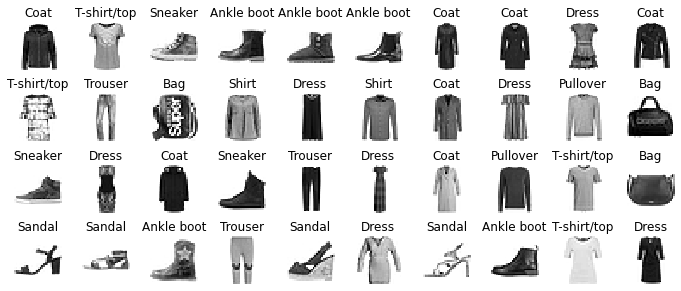

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [22]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [23]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [24]:
model.layers

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [26]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [27]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [28]:
model.get_layer(hidden1.name) is hidden1

True

In [29]:
weights, biases = hidden1.get_weights()

In [30]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [31]:
weights.shape

(784, 300)

In [ ]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
biases.shape

(300,)

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

위 코드는 다음과 같습니다:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [33]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))  ##모델 피팅 

Epoch 1/30
1719/1719 [==============================] - 1s 645us/step - loss: 1.0187 - accuracy: 0.6808 - val_loss: 0.5203 - val_accuracy: 0.8230
Epoch 2/30
1719/1719 [==============================] - 1s 503us/step - loss: 0.5027 - accuracy: 0.8266 - val_loss: 0.4342 - val_accuracy: 0.8536
Epoch 3/30
1719/1719 [==============================] - 1s 501us/step - loss: 0.4481 - accuracy: 0.8425 - val_loss: 0.5307 - val_accuracy: 0.8000
Epoch 4/30
1719/1719 [==============================] - 1s 506us/step - loss: 0.4206 - accuracy: 0.8526 - val_loss: 0.3920 - val_accuracy: 0.8650
Epoch 5/30
1719/1719 [==============================] - 1s 557us/step - loss: 0.4057 - accuracy: 0.8579 - val_loss: 0.3750 - val_accuracy: 0.8688
Epoch 6/30
1719/1719 [==============================] - 1s 506us/step - loss: 0.3752 - accuracy: 0.8676 - val_loss: 0.3708 - val_accuracy: 0.8724
Epoch 7/30
1719/1719 [==============================] - 1s 504us/step - loss: 0.3652 - accuracy: 0.8712 - val_loss: 0.3608 -

In [34]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [ ]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

그림 저장: keras_learning_curves_plot


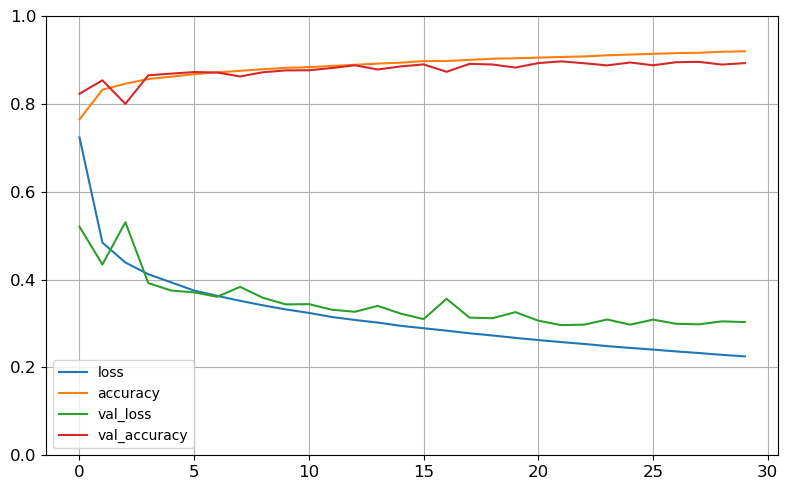

In [36]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [37]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 350us/step - loss: 0.3372 - accuracy: 0.8828


[0.3372422158718109, 0.8827999830245972]

In [38]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[ 6.888519e+22,  0.000000e+00,  6.728976e+08,  9.175700e+02,
         0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00, -0.000000e+00],
       [ 0.000000e+00, -0.000000e+00,           nan,  0.000000e+00,
                  nan,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00, -0.000000e+00,  0.000000e+00, -0.000000e+00,
         0.000000e+00,  0.000000e+00]], dtype=float32)

**경고**: `model.predict_classes(X_new)`는 삭제될 예정입니다. 대신 `np.argmax(model.predict(X_new), axis=-1)`를 사용하세요.

In [39]:
# y_pred = model.predict_classes(X_new)
y_pred = np.argmax(model.predict(X_new), axis=-1) ## same as model.predict_classes(X_new) 클래스 예측하는 함수임 
y_pred

array([0, 2, 9])

In [42]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [40]:
np.array(class_names)[y_pred]

array(['T-shirt/top', 'Pullover', 'Ankle boot'], dtype='<U11')

In [43]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

그림 저장: fashion_mnist_images_plot


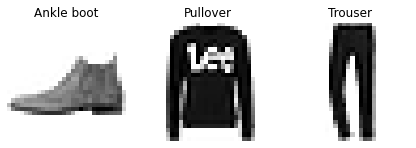

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# 회귀 MLP

캘리포니아 주택 데이터셋을 로드하여 나누고 스케일을 바꾸어 보겠습니다(2장에서 사용한 수정된 버전이 아니라 원본을 사용합니다):

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 3ms/step - loss: 2.2656 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7413 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6604 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6245 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5770 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5609 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5500 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5200 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5051 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4910 - val_loss: 0.4656

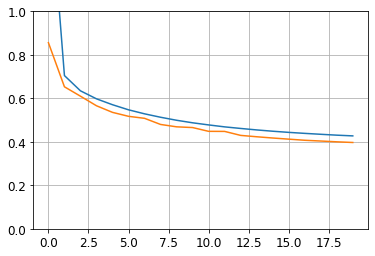

In [ ]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
y_pred

array([[0.38856646],
       [1.6792021 ],
       [3.1022794 ]], dtype=float32)

# 함수형 API

모든 신경망 모델이 단순하게 순서대로 나열되지는 않습니다. 어떤 신경망은 매우 복잡한 구조를 가집니다. 여러 개의 입력이 있거나 여러 개의 출력이 있습니다. 예를 들어 와이드 & 딥 신경망([논문](https://ai.google/research/pubs/pub45413) 참조)은 입력의 전체 또는 일부를 출력층에 바로 연결합니다.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [ ]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 3ms/step - loss: 1.9731 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7638 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6045 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5862 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5452 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5243 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5185 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4947 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4782 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4708 - val_loss: 0.4313

와이드나 딥 경로에 다른 입력 특성을 전달하면 어떻게 될까요? (특성 0에서 4까지) 5개의 특성을 와이드 경로에 보내고 (특성 2에서 7까지) 6개의 특성을 딥 경로에 전달하겠습니다. 3개의 특성(특성 2, 3, 4)은 양쪽에 모두 전달됩니다.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 3.1941 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7247 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6176 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5799 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5409 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5173 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5186 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4977 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4765 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4676 - val_loss: 0.4315

규제를 위한 보조 출력 추가하기:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [ ]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [ ]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 2s 5ms/step - loss: 3.4633 - main_output_loss: 3.3289 - aux_output_loss: 4.6732 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 0.9807 - main_output_loss: 0.7503 - aux_output_loss: 3.0537 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.7742 - main_output_loss: 0.6290 - aux_output_loss: 2.0810 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.6952 - main_output_loss: 0.5897 - aux_output_loss: 1.6449 - val_loss: 1.3388 - val_main_output_loss: 0.5481 - val_aux_output_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 1s 4ms/step - loss: 0.6469 - main_output_loss: 0.5508 - aux_output_loss: 1.5118 - val_loss

In [ ]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 2ms/step - loss: 0.4668 - main_output_loss: 0.4178 - aux_output_loss: 0.9082


# 서브클래싱 API

In [ ]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [ ]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 2s 5ms/step - loss: 3.3855 - output_1_loss: 3.3304 - output_2_loss: 3.8821 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 1s 4ms/step - loss: 1.0790 - output_1_loss: 0.9329 - output_2_loss: 2.3942 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 1s 4ms/step - loss: 0.8644 - output_1_loss: 0.7583 - output_2_loss: 1.8194 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 2s 4ms/step - loss: 0.7850 - output_1_loss: 0.6979 - output_2_loss: 1.5689 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 1s 4ms/step - loss: 0.7294 - output_1_loss: 0.6499 - output_2_loss: 1.4452 - val_loss: 1.1357 - val_output_1_loss: 0.5964 - val_

# 저장과 복원

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.4382


In [ ]:
model.save("my_keras_model.h5")

In [ ]:
model = keras.models.load_model("my_keras_model.h5")

In [ ]:
model.predict(X_new)

array([[0.5400236],
       [1.6505969],
       [3.0098238]], dtype=float32)

In [ ]:
model.save_weights("my_keras_weights.ckpt")

In [ ]:
model.load_weights("my_keras_weights.ckpt")

# 훈련 과정에서 콜백 사용하기

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # 최상의 모델로 롤백
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.4382


In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4578 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4430 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4376 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4361 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4204 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4112 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4226 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4135 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4039 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4023 - val_lo

In [ ]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [ ]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

363/363 [==============================] - 1s 3ms/step - loss: 0.3302 - val_loss: 0.3556

val/train: 1.08


# 텐서보드

In [ ]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [ ]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2021_02_18-03_57_36'

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 2s 5ms/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 1s 3ms/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 1s 3ms/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 1s 3ms/step - loss: 0.4549 - val_loss: 0.4379

텐서보드 서버를 실행하는 한 가지 방법은 터미널에서 직접 실행하는 것입니다. 터미널을 열고 텐서보드가 설치된 가상 환경을 활성화합니다. 그다음 노트북 디렉토리로 이동하여 다음 명령을 입력하세요:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

그다음 웹 브라우저를 열고 [localhost:6006](http://localhost:6006)에 접속하면 텐서보드를 사용할 수 있습니다. 사용이 끝나면 터미널에서 Ctrl-C를 눌러 텐서보드 서버를 종료하세요.

또는 다음처럼 텐서보드의 주피터 확장을 사용할 수 있습니다(이 명령은 텐서보드가 로컬 컴퓨터에 설치되어 있어야 합니다):

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [ ]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2021_02_18-03_58_12'

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 2s 5ms/step - loss: 0.7645 - val_loss: 302.8527
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 4/30
363/363 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 5/30
363/363 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 6/30
363/363 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 7/30
363/363 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 8/30
363/363 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 9/30
363/363 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 10/30
363/363 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 11/30
363/363 [==============================

텐서보드에 실행 결과가 2개 있습니다. 학습 곡선을 비교해 보세요.

사용할 수 있는 로깅 옵션을 확인해 보죠:

In [ ]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# 하이퍼파라미터 튜닝

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [ ]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 1s 3ms/step - loss: 1.5673 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 1s 3ms/step - loss: 1.3216 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5972 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4985 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4608 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4410 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4463 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4283 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4139 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4107 - val_l

In [ ]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3346


In [ ]:
y_pred = keras_reg.predict(X_new)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

**경고**: 다음 셀은 훈련이 끝날 때 에러가 납니다. 이는 최근 사이킷런의 변화때문에 생긴 [케라스 이슈 #13586](https://github.com/keras-team/keras/issues/13586) 때문입니다. 이 이슈를 해결하기 위한 [풀 리퀘스트 #13598](https://github.com/keras-team/keras/pull/13598)가 있으므로 곧 해결될 것 같습니다. 그때까지는 `.tolist()`와 `.rvs(1000).tolist()`를 추가해 사용합니다.

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 1.3827 - val_loss: 0.4703
Epoch 2/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4880 - val_loss: 0.4247
Epoch 3/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4541 - val_loss: 0.4052
Epoch 4/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4518 - val_loss: 0.3975
Epoch 5/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4337 - val_loss: 0.3991
Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4263 - val_loss: 0.4031
Epoch 7/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4385 - val_loss: 0.4043
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4301 - val_loss: 0.3929
Epoch 9/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4108 - val_loss: 0.4040
Epoch 10/100
242/242 [========

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fe464b9ad90>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.0...
                                                          0.00502142573

In [ ]:
rnd_search_cv.best_params_

{'n_neurons': 74, 'n_hidden': 3, 'learning_rate': 0.005803602934201024}

In [ ]:
rnd_search_cv.best_score_

-0.3242675264676412

In [ ]:
rnd_search_cv.best_estimator_

In [ ]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.3104


-0.31039538979530334

In [ ]:
model = rnd_search_cv.best_estimator_.model
model

In [ ]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.3104


0.31039538979530334

# 연습문제 해답

## 1. to 9.

부록 A 참조.

## 10.

*문제: 심층 MLP를 MNIST 데이터셋에 훈련해보세요(`keras.datasets.mnist.load_data()` 함수를 사용해 데이터를 적재할 수 있습니다). 98% 이상의 정확도를 얻을 수 있는지 확인해보세요. 이 장에서 소개한 방법을 사용해 최적의 학습률을 찾아보세요(즉 학습률을 지수적으로 증가시키면서 손실을 그래프로 그립니다. 그다음 손실이 다시 증가하는 지점을 찾습니다). 모든 부가 기능을 추가해보세요. 즉, 체크포인트를 저장하고, 조기 종료를 사용하고, 텐서보드를 사용해 학습 곡선을 그려보세요.*

데이터셋을 적재해보죠:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

패션 MNIST 데이터셋처럼 MNIST 훈련 세트는 28x28 픽셀의 흑백 이미지 60,000개로 이루어져 있습니다:

In [ ]:
X_train_full.shape

(60000, 28, 28)

각 픽셀 강도는 바이트(0~255)로 표현됩니다:

In [ ]:
X_train_full.dtype

dtype('uint8')

전체 훈련 세트를 검증 세트와 (더 작은) 훈련 세트로 나누어 보겠습니다. 패션 MNIST처럼 픽셀 강도를 255로 나누어 0-1 범위의 실수로 변환합니다:

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

맷플롯립의 `imshow()` 함수와 `'binary'` 컬러 맵으로 이미지를 출력해 보죠:

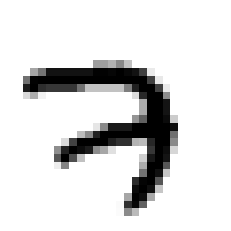

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

레이블은 (uint8로 표현된) 0에서 9까지 클래스 아이디입니다. 편리하게도 클래스 아이디는 이미지가 나타내는 숫자와 같습니다. 따라서 `class_names` 배열을 만들 필요가 없습니다:

In [ ]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

검증 세트는 5,000개의 이미지를 담고 있고 테스트 세트는 10,000개의 이미지를 담고 있습니다:

In [ ]:
X_valid.shape

(5000, 28, 28)

In [ ]:
X_test.shape

(10000, 28, 28)

이 데이터셋에 있는 이미지 샘플 몇 개를 출력해 보죠:

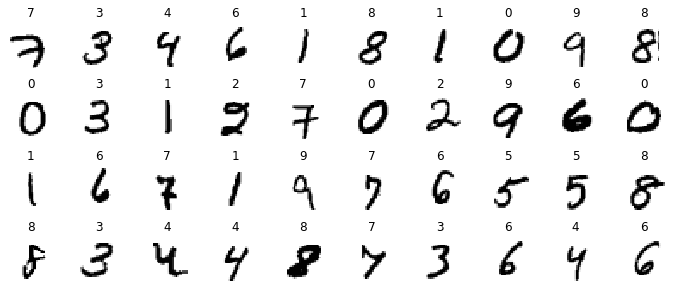

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

간단한 밀집 신경망을 만들고 최적의 학습률을 찾아 보겠습니다. 반복마다 학습률을 증가시키기 위해 콜백을 사용합니다. 이 콜백은 반복마다 학습률과 손실을 기록합니다:

In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

작은 학습률 1e-3에서 시작하여 반복마다 0.5%씩 증가합니다:

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

모델을 1 에포크만 훈련해 보죠:

In [ ]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 7s 4ms/step - loss: inf - accuracy: 0.4934 - val_loss: 2.3911 - val_accuracy: 0.1126


학습률에 대한 함수로 손실을 그릴 수 있습니다:

Text(0, 0.5, 'Loss')

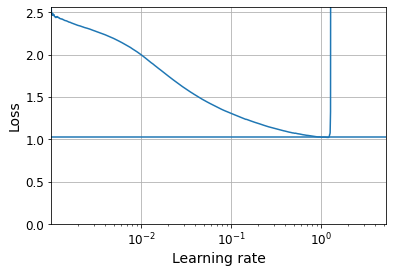

In [ ]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

학습률이 6e-1을 지날 떄 손실이 갑자기 솟구치기 때문에 3e-1을 학습률로 사용하겠습니다:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=3e-1),
              metrics=["accuracy"])

In [ ]:
run_index = 1 # 실행할 때마다 이 값을 늘립니다
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4200 - accuracy: 0.8678 - val_loss: 0.1022 - val_accuracy: 0.9696
Epoch 2/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0937 - accuracy: 0.9701 - val_loss: 0.1104 - val_accuracy: 0.9684
Epoch 3/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0667 - accuracy: 0.9787 - val_loss: 0.0756 - val_accuracy: 0.9778
Epoch 4/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0453 - accuracy: 0.9853 - val_loss: 0.0773 - val_accuracy: 0.9802
Epoch 5/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0349 - accuracy: 0.9890 - val_loss: 0.0867 - val_accuracy: 0.9766
Epoch 6/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0282 - accuracy: 0.9911 - val_loss: 0.0728 - val_accuracy: 0.9830
Epoch 7/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0241 - accuracy: 0.9916 - val_loss: 0.0744 - val_ac

In [ ]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0739 - accuracy: 0.9812


[0.0739181786775589, 0.9811999797821045]

98% 정확도를 얻었습니다. 마지막으로 텐서보드를 사용해 학습 곡선을 살펴보겠습니다:

In [ ]:
%tensorboard --logdir=./my_mnist_logs --port=6006